<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2024/blob/main/Module%202/13_PINN_Cooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Physics-informed neural networks.
- Examples adapted from https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a
- The original repository is https://github.com/TheodoreWolf/pinns/tree/main

# Example of regularization

In [1]:
import numpy as np
from sklearn import linear_model, preprocessing, pipeline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

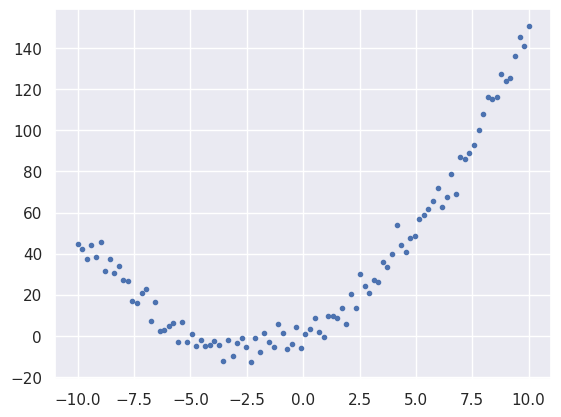

In [2]:
def create_data(n_points):
    x = np.linspace(-10, 10, n_points)
    y = x**2 + 5*x + 1 + 5* np.random.randn(n_points)
    return x, y

x, y = create_data(100)
plt.plot(x,y, '.')

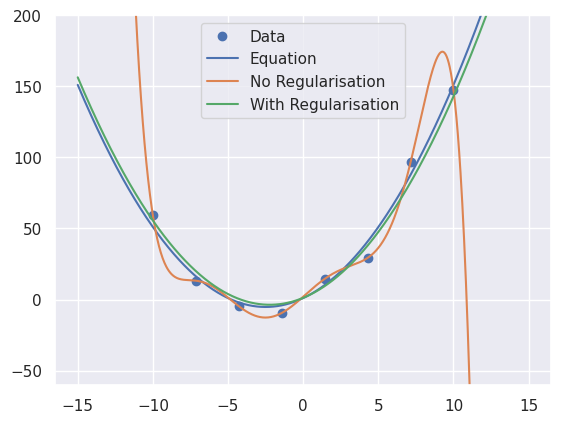

In [3]:
np.random.seed(1)

# Create models
model = pipeline.Pipeline([
    ('poly', preprocessing.PolynomialFeatures(degree=8)),
    ('scaler', preprocessing.StandardScaler()),
    ('model', linear_model.LinearRegression())
    ])

model_l2 = pipeline.Pipeline([
    ('poly', preprocessing.PolynomialFeatures(degree=8)),
    ('scaler', preprocessing.StandardScaler()),
    #('model', linear_model.Ridge(alpha=10))
    ('model', linear_model.Lasso(alpha=3))
    ])

x, y = create_data(8)

model.fit(x.reshape(-1,1), y.reshape(-1,1))
model_l2.fit(x.reshape(-1,1), y.reshape(-1,1))

# Create test data
x_pred = np.linspace(-15, 15, 1000).reshape(-1, 1)

y_pred = model.predict(x_pred)
y_pred_l2 = model_l2.predict(x_pred)

plt.plot(x,y, 'o', label='Data')
plt.plot(x_pred, x_pred**2 + 5*x_pred + 1, label='Equation', color='b')
plt.plot(x_pred, y_pred, label='No Regularisation')
plt.plot(x_pred, y_pred_l2, label='With Regularisation')
plt.ylim(-60, 200)
plt.legend()

In [4]:
# model.*?

In [5]:
model.get_params()

{'memory': None,
 'steps': [('poly', PolynomialFeatures(degree=8)),
  ('scaler', StandardScaler()),
  ('model', LinearRegression())],
 'verbose': False,
 'poly': PolynomialFeatures(degree=8),
 'scaler': StandardScaler(),
 'model': LinearRegression(),
 'poly__degree': 8,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__n_jobs': None,
 'model__positive': False}

In [6]:
linear_model_coef = model.named_steps['model'].coef_
print(linear_model_coef)

intercept = model.named_steps['model'].intercept_
print(intercept)

[[-1.91535676e-12  6.11962763e+01  8.60701603e+00 -2.63172697e+02
   7.35267543e+01  6.28142987e+02  4.61085381e+00 -3.97404909e+02
  -4.88821804e+01]]
[43.20646934]


In [7]:
linear_model_coef_l2 = model_l2.named_steps['model'].coef_
print(linear_model_coef_l2)

intercept_l2 = model_l2.named_steps['model'].intercept_
print(intercept_l2)

[ 0.         28.60098516 36.68669785  0.          0.          0.
  0.          0.          0.        ]
[43.20646934]


# Network class

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []

        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)

            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))

In [9]:
import torch
import numpy as np

def grad(outputs, inputs):
    """Computes the partial derivative of
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

# Cooling data generation

In [10]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

Text(0.5, 0, 'Time (s)')

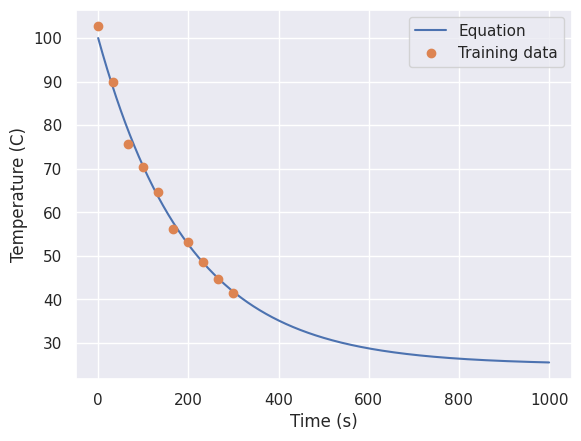

In [11]:
np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Epoch 0/20000, loss: 4713.88
Epoch 2000/20000, loss: 2510.80
Epoch 4000/20000, loss: 2149.53
Epoch 6000/20000, loss: 729.29
Epoch 8000/20000, loss: 86.61
Epoch 10000/20000, loss: 1.75
Epoch 12000/20000, loss: 0.43
Epoch 14000/20000, loss: 0.36
Epoch 16000/20000, loss: 0.35
Epoch 18000/20000, loss: 0.34


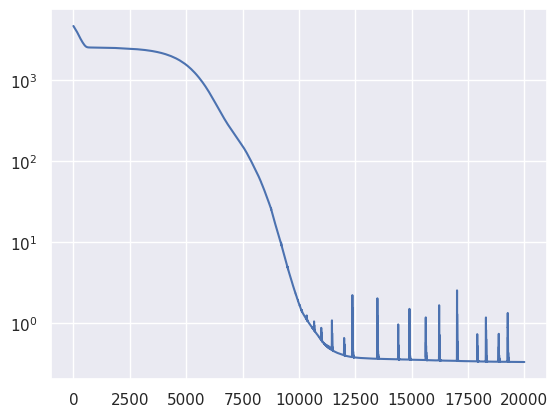

In [12]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

In [13]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/40000, loss: 11220.99
Epoch 4000/40000, loss: 2440.25
Epoch 8000/40000, loss: 1204.67
Epoch 12000/40000, loss: 917.70
Epoch 16000/40000, loss: 777.14
Epoch 20000/40000, loss: 645.97
Epoch 24000/40000, loss: 542.92
Epoch 28000/40000, loss: 459.31
Epoch 32000/40000, loss: 394.46
Epoch 36000/40000, loss: 343.33


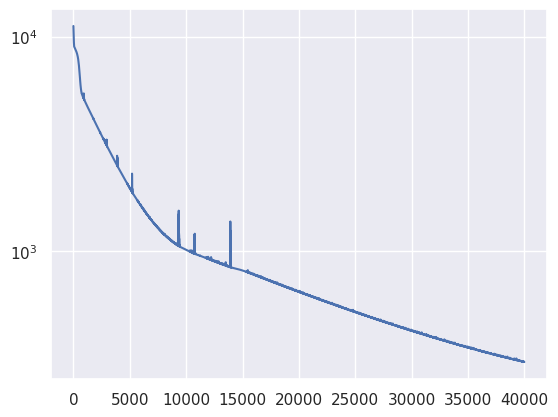

In [14]:
netreg = Net(1,1, loss2=l2_reg, epochs=40000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

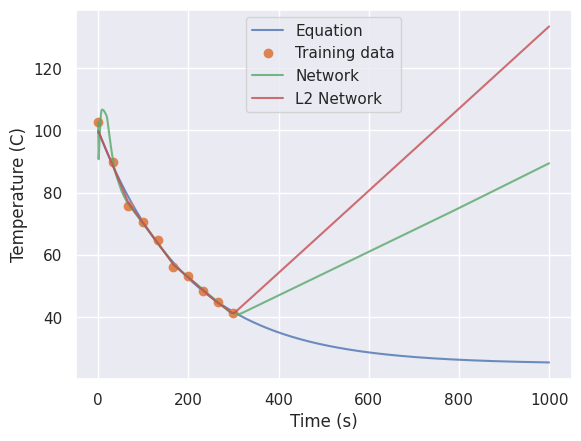

In [15]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

# PINN Prediction

In [16]:
R1 = 3 * R #0.0000000003

def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R1*(Tenv - temps) - dT

    return torch.mean(pde**2)

Epoch 0/12000, loss: 4777.06
Epoch 1200/12000, loss: 2551.61
Epoch 2400/12000, loss: 2485.72
Epoch 3600/12000, loss: 2234.99
Epoch 4800/12000, loss: 1525.72
Epoch 6000/12000, loss: 495.41
Epoch 7200/12000, loss: 99.82
Epoch 8400/12000, loss: 11.67
Epoch 9600/12000, loss: 2.63
Epoch 10800/12000, loss: 1.74


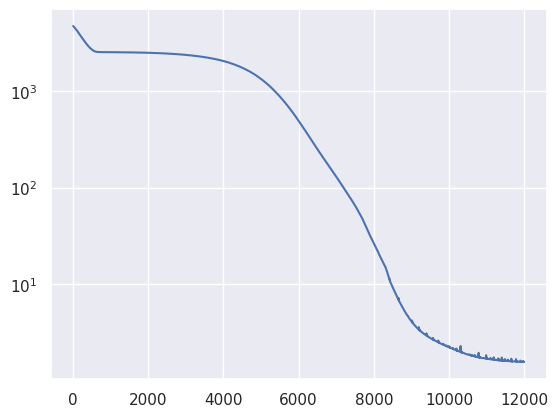

In [17]:
net = Net(1,1, loss2=physics_loss, epochs=12000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

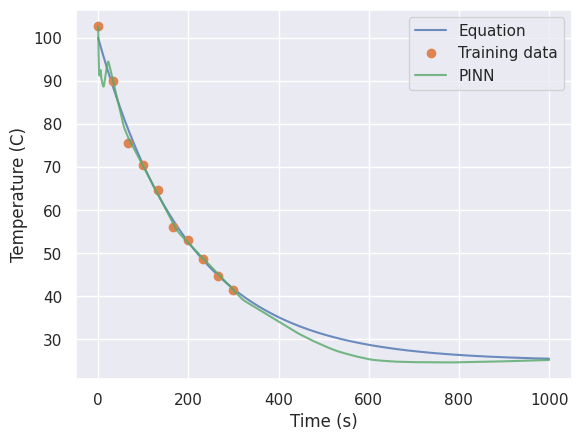

In [18]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

# PINN Parameter Discovery

In [19]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT

    return torch.mean(pde**2)

Epoch 0/40000, loss: 4817.01
Epoch 4000/40000, loss: 2500.86
Epoch 8000/40000, loss: 2038.14
Epoch 12000/40000, loss: 473.42
Epoch 16000/40000, loss: 4.57
Epoch 20000/40000, loss: 2.63
Epoch 24000/40000, loss: 2.13
Epoch 28000/40000, loss: 1.57
Epoch 32000/40000, loss: 1.36
Epoch 36000/40000, loss: 1.26


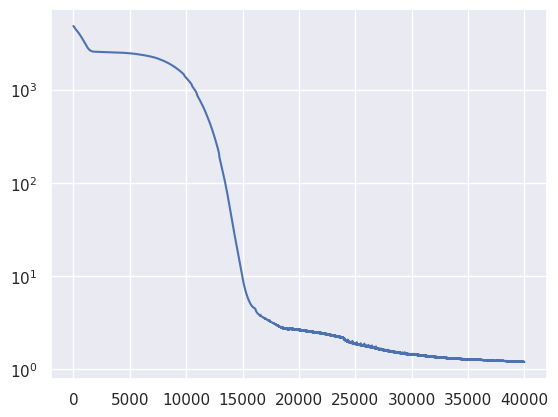

In [20]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0050], device='cuda:0', requires_grad=True)


Text(0.5, 0, 'Time (s)')

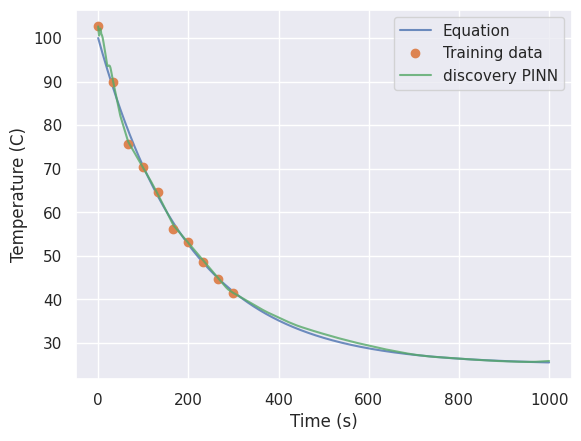

In [21]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')